# Kitaev20

## Introduction

## Init

In [26]:
import classifim.bench.fidelity
import classifim.bench.metric

import classifim_gen.fft
import classifim_gen.gs_cache
import classifim_gen.kitaev20_dataset
import classifim_gen.kitaev_hamiltonian
import classifim_gen.hubbard_hamiltonian
import classifim_gen.io
import classifim.utils
import cmath
import concurrent.futures
import datetime
import functools
import gradient_descent_the_ultimate_optimizer
import importlib
import math
import matplotlib
import matplotlib.pyplot as plt
import my.utils as myu
import numpy as np
import os
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import scipy.sparse.linalg
import sys

from gradient_descent_the_ultimate_optimizer import gdtuo
from tqdm import tqdm

The following settings were used to generate the images for the main paper. They are commented out (the cell is made "raw" using CTRL+R, use CTRL+Y to make it "code") since they require a LaTeX installation with some fonts and packages used by matplotlib.

In [2]:
# [Optional]: matplotlib.backend_bases.register_backend('pgf', FigureCanvasPgf)
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [3]:
SM_NAME = "kitaev_20"
SM_NAME_PRINT = "Kitaev20"
DATA_DIR0 = classifim.utils.find_data_dir()
assert os.path.isdir(DATA_DIR0)
DATA_DIR = classifim.utils.maybe_create_subdir(DATA_DIR0, SM_NAME)
print(f"{DATA_DIR=}")

HF_DATA_DIR0 = classifim.utils.find_data_dir("hf_data_dir")
HF_DATA_DIR = classifim.utils.maybe_create_subdir(HF_DATA_DIR0, SM_NAME)

DATA_DIR='/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/kitaev_20'


In [4]:
ham_family = classifim_gen.kitaev_hamiltonian.KitaevFamily(L=20)

## Data generation

### FermFT

* Requires: nothing
* Generates: fermft_out/dataset_{seed}.npz

In [5]:
def top_evals_rhoA(phi, n=10):
    L = int(0.5 + math.log2(phi.shape[0]))
    assert phi.shape == (1 << L,)
    assert L % 2 == 0
    # Can't request more eigenvalues than size of the density matrix:
    assert n <= (1 << (L // 2))
    
    rho_a = phi.reshape((2**(L//2), 2**(L//2)))
    # rho_a[i_low, j_low] = sum_{i_high=0,...,2^{L_a}-1}(phi[i_high, i_low] * phi[i_high, j_low]^\dagger):
    rho_a = rho_a.T @ np.conj(rho_a)
    evals = scipy.linalg.eigvalsh(rho_a)
    return evals[:-n-1:-1]

In [9]:
# This covers [0, 1]:
mus_cnt = 2 * 10**4
mus = (np.arange(-1, mus_cnt) + 0.5) / mus_cnt
# This covers [-4, 4]:
mus = -4 + 8 * mus
prev_mu = mus[0]
mus = mus[1:]
kitaev_dataset = {
    "seed": 42,
    "param.t": 1.0,
    "param.delta": 1.0,
    "param.mus": [],
    "ts": [],
    "deltas": [],
    "samples": [],
    "top_10": [],
    "chi_f": []
}
prev_gs = ham_family.get_coordinate_basis_ground_state(t=1.0, delta=1.0, mu=prev_mu)
rng = np.random.default_rng(kitaev_dataset["seed"])
L = ham_family.L

print(f"Start: {datetime.datetime.now():%Y-%m-%d %H:%M:%S}")
for mu_val in tqdm(mus):
    gs = ham_family.get_coordinate_basis_ground_state(
        t=kitaev_dataset["param.t"],
        delta=kitaev_dataset["param.delta"],
        mu=mu_val)
    kitaev_dataset["ts"].append(1.0)
    kitaev_dataset["deltas"].append(1.0)
    kitaev_dataset["param.mus"].append(mu_val)
    kitaev_dataset["samples"].append(
            rng.choice(1<<L, size=140, replace=True, p=np.abs(gs)**2))
    kitaev_dataset["top_10"].append(top_evals_rhoA(gs, n=10))
    kitaev_dataset["chi_f"].append(np.abs(prev_gs.conj() @ gs))
    prev_gs = gs

ds_keys = list(kitaev_dataset.keys())
for key in ds_keys:
    value = kitaev_dataset[key]
    if isinstance(value, list):
        kitaev_dataset[key] = np.array(value)

DATASET_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "fermft_out")
np.savez_compressed(
    os.path.join(DATASET_DIR, f"dataset_{kitaev_dataset['seed']}v1.npz"), **kitaev_dataset)

Start: 2023-09-19 11:05:00


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [5:49:36<00:00,  1.05s/it]


Or if generated using batch jobs, join into one file:

In [47]:
batch_dataset_dir = os.path.expanduser("~/Dropbox (Lidar group)/qc4ml_work/aaai24_kitaev20/fermft_out/")
kitaev_dataset = {}
scalar_keys = set(["seed", "param.t", "param.delta"])
ignored_keys = set(["ts", "deltas"])
other_keys = []
for i in range(100):
    npz = np.load(os.path.join(batch_dataset_dir, f"dataset_42_{i}.npz"))
    num_rows = None
    for key, value in npz.items():
        if key in ignored_keys:
            continue
        if key in scalar_keys:
            if i == 0:
                kitaev_dataset[key] = value
            else:
                assert kitaev_dataset[key] == value
            continue
        if i == 0:
            other_keys.append(key)
            kitaev_dataset[key] = []
        else:
            assert key in other_keys, f"{key}"
        if num_rows is None:
            num_rows = value.shape[0]
        else:
            assert num_rows == value.shape[0]
        kitaev_dataset[key].append(value)
for key in other_keys:
    kitaev_dataset[key] = np.concatenate(kitaev_dataset[key])

In [48]:
DATASET_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "fermft_out")
filename = os.path.join(DATASET_DIR, f"dataset_{kitaev_dataset['seed']}v1.npz")
np.savez_compressed(
    filename, **kitaev_dataset)
print(f"Dataset saved to {filename}")

Dataset saved to /run/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/kitaev20/fermft_out/dataset_42v1.npz


### Generate datasets

In [50]:
npz42 = dict(np.load(f"{DATA_DIR}/fermft_out/dataset_42v1.npz"))

In [70]:
for key, value in npz42.items():
    print(f"{key}: {value.shape} {value.dtype}")

seed: () int64
param.t: () float64
param.delta: () float64
param.mus: (20000,) float64
samples: (20000, 1400) int64
top_20: (20000, 20) float64
chi_f: (20000,) float64


In [63]:
example_ds = dict(np.load("/run/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/fil1d20/classifim_datasets/dataset_42.npz"))
for key, value in example_ds.items():
    print(f"{key}: {value.shape} {value.dtype}")

lambdas: (573440, 2) float64
zs: (573440,) uint32
seed: () int64


In [69]:
CLASSIFIM_DATASET_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "classifim_datasets")
datasets = classifim_gen.kitaev20_dataset.generate_kitaev20_datasets(
    npz42,
    payload={
        "fermft_seed": npz42["seed"],
        "param.t": npz42["param.t"],
        "param.delta": npz42["param.delta"]
    })
for dataset in datasets:
    seed = dataset["fermft_seed"]
    dataset_i = dataset["dataset_i"]
    dataset_file_name = os.path.join(CLASSIFIM_DATASET_DIR, f"dataset_{seed}_{dataset_i}.npz")
    np.savez_compressed(dataset_file_name, **dataset)
    print(f"Dataset is saved to '{dataset_file_name}'")

Dataset is saved to '/run/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/kitaev20/classifim_datasets/dataset_42_0.npz'
Dataset is saved to '/run/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/kitaev20/classifim_datasets/dataset_42_1.npz'
Dataset is saved to '/run/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/kitaev20/classifim_datasets/dataset_42_2.npz'
Dataset is saved to '/run/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/kitaev20/classifim_datasets/dataset_42_3.npz'
Dataset is saved to '/run/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/kitaev20/classifim_datasets/dataset_42_4.npz'
Dataset is saved to '/run/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/kitaev20/classifim_datasets/dataset_42_5.npz'
Dataset is saved to '/run/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/kitaev20/classifim_datasets/dataset_42_6.npz'
Dataset is saved to '/run/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/ne

### Compute ground truth FIM

In [33]:
def spectrum_fim_1d(x, spectrum, cutoff):
    n_points, n_evals = spectrum.shape
    assert x.shape == (n_points,)
    assert np.all(np.sum(spectrum, axis=1) <= 1.0)
    assert np.all(spectrum >= 0)
    assert n_evals >= cutoff
    spectrum = spectrum[:, :cutoff]
    spectrum_o = 1.0 - np.sum(spectrum, axis=1)
    fim = (
        1.0 - np.sum((spectrum[:-1] * spectrum[1:])**0.5, axis=1)
        - (spectrum_o[:-1] * spectrum_o[1:])**0.5)
    dx = x[1:] - x[:-1]
    x1 = (x[1:] + x[:-1]) / 2
    fim = fim * 8 / dx**2
    return x1, np.maximum(fim, 0)

In [48]:
npz42 = dict(np.load(os.path.join(DATA_DIR, "fermft_out", "dataset_42v1.npz")))
gt_fim = {
    "param.delta": npz42["param.delta"]
}
spectrum = npz42["top_20"]
lambda0s = npz42["param.mus"]
dlambda0s = lambda0s[1:] - lambda0s[:-1]
gt_fim["lambda0"], gt_fim["fim_10"] = spectrum_fim_1d(lambda0s, spectrum, cutoff=10)
# chi_f here is a misnomer:
fidelity = npz42["chi_f"][1:]
gt_fim["fim"] = (1.0 - fidelity) * 8 / dlambda0s**2

description = {
    "lambda0": "midpoints from npz42['param.mus']: these are the points were FIM is evaluated.",
    "param.delta": "Copy from npz42",
    "top10_fim": "FIM of the distribution implied by 'top10' entanglement spectrum at points given by param.mus",
    "fim": "FIM at points given by param.mus; fim is with respect to lambda0"}
gt_fim["description"] = "Ground truth FIM\n" + (
    "\n".join(f'"{key}": "{value}"' for key, value in description.items()))
gt_fim_filename = os.path.join(DATA_DIR, "fim", "gt_fim.npz")
np.savez_compressed(gt_fim_filename, **classifim.bench.fidelity.encode_for_npz(gt_fim))
print(f"Saved gt_fim to '{gt_fim_filename}'.")

Saved gt_fim to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/kitaev_20/fim/gt_fim.npz'.


### Convert to parquet

In [49]:
with np.load(os.path.join(DATA_DIR, "fim", "gt_fim.npz")) as f:
    fim_npz = dict(f)
gt_fim_filename = os.path.join(HF_DATA_DIR, "gt_fim.parquet")
pq.write_table(
    pa.Table.from_pydict({
        k: v
        for k, v in fim_npz.items()
        if k not in ["description", "param.delta"]
    }),
    gt_fim_filename)

In [46]:
extra_metadata = {}
for k, v in fim_npz.items():
    if isinstance(v, np.ndarray):
        if v.size == 1:
            v = v.item()
        else:
            continue
    if k == "description":
        extra_metadata["gt_fim.description"] = v
        continue
    extra_metadata[k] = v

data_seeds = classifim_gen.io.save_datasets_for_hf(
    convert_f=classifim_gen.kitaev20_dataset.convert_dataset_to_hf,
    input_pattern=os.path.join(DATA_DIR, "classifim_datasets", "dataset_42_{seed}.npz"),
    output_dir=HF_DATA_DIR,
    overwrite=True,
    extra_metadata=extra_metadata)
print("Done.")

Done.


In [47]:
print(classifim_gen.io.gen_config_yml(
    sm_name=os.path.basename(HF_DATA_DIR),
    seeds=sorted(data_seeds),
    fim_seeds=None))

- config_name: kitaev_20.gt_fim
  data_files:
  - split: test
    path: kitaev_20/gt_fim.parquet
- config_name: kitaev_20.seed00
  data_files:
  - split: train
    path: kitaev_20/seed_00/d_train.parquet
  - split: test
    path: kitaev_20/seed_00/d_test.parquet
- config_name: kitaev_20.seed01
  data_files:
  - split: train
    path: kitaev_20/seed_01/d_train.parquet
  - split: test
    path: kitaev_20/seed_01/d_test.parquet
- config_name: kitaev_20.seed02
  data_files:
  - split: train
    path: kitaev_20/seed_02/d_train.parquet
  - split: test
    path: kitaev_20/seed_02/d_test.parquet
- config_name: kitaev_20.seed03
  data_files:
  - split: train
    path: kitaev_20/seed_03/d_train.parquet
  - split: test
    path: kitaev_20/seed_03/d_test.parquet
- config_name: kitaev_20.seed04
  data_files:
  - split: train
    path: kitaev_20/seed_04/d_train.parquet
  - split: test
    path: kitaev_20/seed_04/d_test.parquet
- config_name: kitaev_20.seed05
  data_files:
  - split: train
    path: 

# FFT

In [47]:
rng = np.random.default_rng(1)
L = 20
psi = rng.normal(size=(2, 1<<L))
psi = psi / np.linalg.norm(psi)
psi = psi[0] + psi[1] * 1j
assert psi.dtype == np.complex128

In [48]:
%%time
phi = classifim_gen.fft.fermionic_fourier(psi)

CPU times: user 1.34 s, sys: 1.15 s, total: 2.5 s
Wall time: 785 ms


In [49]:
%%time
rho_a = phi.reshape((2**(L//2), 2**(L//2)))
# rho_a[i_low, j_low] = sum_{i_high=0,...,2^{L_a}-1}(phi[i_high, i_low] * phi[i_high, j_low]^\dagger):
rho_a = rho_a.T @ np.conj(rho_a)
evals = scipy.linalg.eigvalsh(rho_a)
top_10 = evals[:-10:-1]

CPU times: user 1.53 s, sys: 972 ms, total: 2.5 s
Wall time: 222 ms


In [51]:
evals[-100]

0.002551592042542838

In [15]:
rotation = (np.array([[1, 1], [1, -1]], dtype=np.complex128) / 2**0.5, (0, 7))

In [13]:
%%timeit -n 10
phi =   classifim_gen.fft.fermionic_fourier(psi)

752 ms ± 7.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%%timeit -n 10
phi = classifim_gen.fft._apply_rotation_inplace(rotation, psi.copy())

26.8 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [110]:
def my_print_matrix(a):
    for i in range(a.shape[0]):
        if i == 0:
            print("[[", end="")
        else:
            print(" [", end="")
        for j in range(a.shape[1]):
            if j > 0:
                print(", ", end="")
            a_str = f"{a[i, j]:.3f}"
            print(f"{a_str:>13s}", end="")
        if i == a.shape[0] - 1:
            print("]]")
        else:
            print("]")
            
my_print_matrix(np.conj(res_f.T) @ expected_f)

[[ 1.000+0.000j, -0.000-0.000j,  0.000-0.000j]
 [ 0.000+0.000j,  1.000-0.000j,  0.000-0.000j]
 [ 0.000-0.000j,  0.000+0.000j,  1.000+0.000j]]


In [111]:
my_print_matrix(a)

[[ 1.000+0.000j, -0.000-0.000j,  0.000-0.000j]
 [ 0.000+0.000j,  1.000+0.000j,  0.000-0.000j]
 [ 0.000-0.000j,  0.000+0.000j,  1.000+0.000j]]


In [84]:
np.allclose(a, np.eye(3))

False

In [73]:
my_print_matrix(np.conj(a.T) @ a)

[[ 1.000+0.000j, -0.000-0.000j,  0.000-0.000j]
 [-0.000+0.000j,  1.000+0.000j,  0.000-0.000j]
 [ 0.000+0.000j,  0.000+0.000j,  1.000+0.000j]]


In [74]:
np.allclose(np.conj(expected_f.T) @ expected_f, np.eye(3))

True

In [7]:
%%timeit -n 10
sign = 
zs1 = 1 - ((zs & 1) << 1)

1.69 ms ± 202 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# FFT: Givens decomposition

## Givens decomposition: planted solution

In [8]:
def lapply_givens_rotation(g, rows, a):
    """
    Multiply a matrix a by a single givens rotation on the left.
    """
    rows = list(rows)
    a[rows, :] = g @ a[rows, :]

# Function to reconstruct Q from P, D, rotations
def reconstruct_q(p, d, rotations):
    q = np.eye(p.shape[0], dtype=np.complex128)
    for g, ij in reversed(rotations):
        lapply_givens_rotation(g, ij, q)
    q = p @ d @ q
    return q

# Function to sample P:
def random_permutation_matrix(rng, n):
    p = np.zeros(shape=(n,n), dtype=np.complex128)
    p[np.arange(n), rng.choice(n, size=n, replace=False)] = 1
    return p

# Function to sample D:
def random_diagonal_matrix(rng, n):
    return np.diag(np.exp(rng.uniform(low=0, high=2 * math.pi, size=n) * 1j))

# Given 2 angles, return the corresponding complex Givens 2x2 matrix:
def givens_from_angles(gtheta, gphi):
    cos_gtheta = np.cos(gtheta)
    sin_gtheta = np.sin(gtheta)
    exp_igphi = np.exp(gphi * 1j)
    g = np.array([
            [cos_gtheta, -exp_igphi * sin_gtheta],
            [sin_gtheta, exp_igphi * cos_gtheta]],
        dtype=np.complex128)
    return g

def random_givens_rotation(rng, n, excluded_pairs=[]):
    index_pairs = [(i, j) for i in range(1, n) for j in range(i)]
    index_pairs = list(set(index_pairs) - set(excluded_pairs))
    ij = tuple(rng.choice(index_pairs))
    g = givens_from_angles(*rng.uniform(0, 2 * math.pi, size=2))
    return g, ij

def random_givens_rotations(rng, n, k):
    if k == 0:
        return []
    assert n >= 2
    assert n >= 3 or k == 1
    res = []
    excluded_pairs = []
    for _ in range(k):
        g, ij = random_givens_rotation(rng, n, excluded_pairs)
        res.append((g, ij))
        # ij is excluded because two ij rotations in a row would simplify into a single one.
        # rotations which commute with ij and were excluded are still excluded.
        excluded_pairs = [ij1 for ij1 in excluded_pairs if len(set(ij1 + ij)) == 4] + [ij]
    return res

n = 5
orig_k = 7
rng = np.random.default_rng(seed=1)
q = np.zeros(1)
while np.sum(q==0) > 0:
    # orig_p = random_permutation_matrix(rng, n)
    orig_p = np.eye(n)
    orig_d = random_diagonal_matrix(rng, n)
    orig_rotations = random_givens_rotations(rng, n, orig_k)
    q = reconstruct_q(orig_p, orig_d, orig_rotations)

assert q.shape == (n, n)
assert q.dtype == np.complex128
assert np.allclose(q @ np.conj(q.T), np.eye(n))

NameError: name 'math' is not defined

In [338]:
def absorb_diagonal(d, rotations):
    n = d.shape[0]
    assert d.shape == (n, n)
    d = np.diag(d).copy()
    res_rotations = []
    for g, ij in rotations:
        ij_list = list(ij)
        new_g = g * d[ij_list, None]
        d[ij_list] = 1.0 + 0.0j
        res_rotations.append((new_g, ij))
    return np.diag(d), res_rotations

def rotations_to_h(rotations, n):
    """
    Convert a list of 2x2 rotations into a tensor with corresponding matrices.
    
    Args:
        rotations: list, each element of which is a tuple `(g, (i, j))`, where
            g: 2x2 matrix
            i, j: indices where to put the values of that matrix.
        n: target matrix size
    
    Returns:
        np.ndarray of shape `(k, n, n)`, where `k = len(rotations)`.
        The resulting array `res` coincides with `k` copies of identity matrix
        except for elements specified in the `rotations` array.
    """
    k = len(rotations)
    res = np.tile(np.eye(n, dtype=np.complex128), (k, 1, 1))
    
    # Iterate through the rotations list and fill in the matrices
    for idx, (g, (i, j)) in enumerate(rotations):
        res[idx, [i, i, j, j], [i, j, i, j]] = g[[0, 0, 1, 1], [0, 1, 0, 1]]
    
    return MinimalGivensDecomposition.logm_unitary(torch.tensor(res)).numpy()

In [339]:
new_d, new_rotations = absorb_diagonal(orig_d, orig_rotations)
assert np.allclose(new_d, np.eye(n))
new_q = reconstruct_q(np.eye(n), np.eye(n), new_rotations)
assert np.allclose(new_q, q)
new_h = rotations_to_h(new_rotations, n)

## Torch: Minimal Givens Decomposition

In [101]:
def batch_randperm(batch_size, n, dtype=torch.int64):
    base = torch.arange(n, dtype=dtype).repeat(batch_size, 1)
    rand_indices = torch.rand(batch_size, n).argsort(dim=1, descending=False)
    output = torch.gather(base, 1, rand_indices)
    return output

In [102]:
# This is slower than batch_randperm.
def batch_randperm_v2(batch_size, n, dtype=torch.int64):
    res = torch.arange(n, dtype=dtype).repeat(batch_size, 1)
    ii = torch.arange(batch_size, dtype=torch.int64)
    tmp = torch.zeros(batch_size, dtype=dtype)
    idx = torch.zeros(batch_size, dtype=torch.int64)
    for j in reversed(range(1, n-1)):
        torch.randint(j+1, (batch_size,), out=idx)
        tmp[:] = res[:, j]
        res[:, j] = res[ii, idx]
        res[ii, idx] = tmp[:]
    return res

In [103]:
%%timeit -n 10
_ = batch_randperm_v2(2**14, 256)

77.6 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [100]:
%%timeit -n 10
_ = batch_randperm(2**14, 256)

41.2 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
import torch

class GivensLoss(torch.autograd.Function):

    @staticmethod
    def _get_ij(h):
        n = h.shape[-1]
        n2 = n * n
        # Compute the non-differentiable part.
        d = torch.abs(torch.diagonal(h, dim1=-2, dim2=-1))**2
        a = torch.abs(h)**2 + (d[..., :, None] + d[..., None, :]) / 2
        a.diagonal(dim1=-2, dim2=-1).fill_(0)
        a = a.view(-1, n2)
        ij = torch.argmax(a, dim=1)
        i = torch.div(ij, n, rounding_mode="floor")
        j = ij % n
        return i, j
    
    @staticmethod
    def get_ij(h):
        res_shape = h.shape[:-2]
        i0, j0 = GivensLoss._get_ij(h)
        i = torch.minimum(i0, j0).reshape(res_shape)
        j = torch.maximum(i0, j0).reshape(res_shape)
        return i, j
    
    @staticmethod
    def forward(ctx, h):
        n = h.shape[-1]
        n2 = n * n
        batch_size = torch.prod(torch.tensor(h.shape)).item() // n2
        i, j = GivensLoss._get_ij(h)

        # Compute the differentiable part.
        h1 = h.clone()
        h1v = h1.view(batch_size, n, n)
        batch_idx = torch.arange(batch_size, dtype=int)
        h1v[batch_idx, i, i] = 0
        h1v[batch_idx, i, j] = 0
        h1v[batch_idx, j, i] = 0
        h1v[batch_idx, j, j] = 0
        ctx.save_for_backward(h1)

        return torch.linalg.matrix_norm(h1, ord='fro', dim=(-2, -1))**2
    
    @staticmethod
    def make_sparse(h, keep=None):
        n = h.shape[-1]
        n2 = n * n
        batch_size = torch.prod(torch.tensor(h.shape)).item() // n2

        i, j = GivensLoss._get_ij(h)
        batch_idx = torch.arange(batch_size, dtype=int)
        hv = h.view(batch_size, n, n)
        if keep is None:
            res = torch.zeros((batch_size, n, n), dtype=torch.cdouble)
        else:
            assert isinstance(keep, float)
            res = hv.clone() * keep
        res[batch_idx, i, i] = hv[batch_idx, i, i]
        res[batch_idx, i, j] = hv[batch_idx, i, j]
        res[batch_idx, j, i] = hv[batch_idx, j, i]
        res[batch_idx, j, j] = hv[batch_idx, j, j]
        return res.reshape(h.shape)

    @staticmethod
    def backward(ctx, grad_output):
        assert not torch.isnan(grad_output).any()
        h1, = ctx.saved_tensors
        return 2 * h1 * grad_output[..., None, None]

rng = np.random.default_rng(2)
x_shape = (2, 2, 4, 4)
x = rng.normal(size=x_shape) + 1j * rng.normal(size=x_shape)
x = torch.tensor(x + np.moveaxis(x, -1, -2).conj(), dtype=torch.cdouble, requires_grad=True)
print(f"GivensLoss grad check: {torch.autograd.gradcheck(GivensLoss.apply, x)}")

def square_product_mismatch(h, q):
    g = torch.linalg.matrix_exp(1j * h)
    g_list = [g[..., j1, :, :] for j1 in range(g.shape[-3])]
    prod_g = functools.reduce(torch.matmul, g_list)
    diff = prod_g - q[None, :, :]

    return torch.linalg.matrix_norm(diff, ord='fro', dim=(-2, -1))**2

GivensLoss grad check: True


In [346]:
class MinimalGivensDecomposition(torch.nn.Module):
    def __init__(self, q, num_samples=16384, num_matrices=7, n=5,
                 sampler_version=4, oversampling_ratio=8):
        super(MinimalGivensDecomposition, self).__init__()
        self.q = torch.tensor(q)
        # h = self.sample_h((num_samples, num_matrices), n=n)
        if sampler_version == 1:
            h = self.sample_h((num_samples, num_matrices), n)
            self.prev_losses = None
        else:
            assert sampler_version == 4
            h, self.prev_losses = self.sample_h_v4(
                num_orig_samples=int(num_samples * oversampling_ratio + 0.5),
                num_samples=num_samples,
                num_matrices=num_matrices, n=n)
        self.h = torch.nn.Parameter(h)

    @staticmethod
    def sample_h(batch_size, n):
        if isinstance(batch_size, int):
            batch_size=(batch_size,)
        h_shape = batch_size + (n, n)
        h0 = torch.randn(h_shape, dtype=torch.cdouble)
        hq, _ = torch.linalg.qr(h0)
        hr_diag = 2 * torch.rand(batch_size + (n,), dtype=torch.double) - 1
        hr_diag = (hr_diag * math.pi).to(dtype=torch.cdouble)
        hr = torch.diag_embed(hr_diag)
        h = hq @ hr @ hq.conj().transpose(-2, -1)
        return h
    
    @staticmethod
    def logm_unitary(g):
        """
        For a unitary matrix g, return h s.t. g = exp(1j * h).
        
        That is, compute -1j * log(g).
        
        Eigenvalues of `h` are in `[-pi, pi]`.
        """
        eigenvalues, eigenvectors = torch.linalg.eig(g)
        eigenvalues_angle = torch.angle(eigenvalues)
        # Ensure the angle is in [-pi, pi]:
        eigenvalues_angle = (eigenvalues_angle + cmath.pi) % (2 * cmath.pi) - cmath.pi

        # Reconstruct log_q using the diagonalized eigenvalues
        log_eigenvalues = eigenvalues_angle.to(dtype=torch.cdouble)
        log_g = torch.matmul(
            eigenvectors,
            torch.matmul(
                log_eigenvalues.diag_embed(), torch.linalg.inv(eigenvectors)))
        return log_g
    
    @staticmethod
    def replace_hj(h, q, j, mode='full'):
        num_samples = h.shape[0]
        k = h.shape[1]
        n = h.shape[2]
        assert h.shape == (num_samples, k, n, n)
        if isinstance(j, int):
            assert j < k
            j = torch.full(fill_value=j, size=(num_samples,))
        else:
            assert torch.all(j < k)
        # g[j] = g[j-1]^{-1} * g[0]^{-1} * q * g[k-1]^{-1} * ... * g[j+1]^{-1}
        g_list = torch.zeros((k, num_samples, n, n), dtype=torch.cdouble)
        ii0 = torch.arange(num_samples)
        g_list[j, ii0, :, :] = q[None, :, :]
        # k-1, k-2, ..., j+1, j-1, ..., 0:
        j_in = torch.full(fill_value=k, size=(num_samples,))
        j_out = j.clone() # j+1, ..., k-1, 0, ..., j-1
        for _ in range(k-1):
            j_in -= 1
            j_out += 1
            at_end = (j_in == j).to(dtype=torch.int64)
            at_end2 = (j_out == k).to(dtype=torch.int64)
            j_in -= at_end
            j_out -= at_end * k
            g_list[j_out, ii0, :, :] = torch.linalg.matrix_exp(-1j * h[ii0, j_in, :, :])
        hj = MinimalGivensDecomposition.logm_unitary(
            functools.reduce(torch.matmul, g_list))
        if mode == 'full':
            pass
        elif mode == 'sparse':
            hj = GivensLoss.make_sparse(hj)
        else:
            assert isinstance(mode, float)
            hj = GivensLoss.make_sparse(hj, keep=mode)
        h[ii0, j, :, :] = hj
    
    def replace_hj_loops(self, h, num_loops=1, mode=1e-3):
        k = h.shape[1]
        if mode == "spread_loss":
            assert num_loops >= 1
            for j0, j in enumerate(batch_randperm(h.shape[0], k).T):
                total_weight = k - j0 + 1 / k
                self.replace_hj(h, q=self.q, j=j, mode=1.0 / total_weight)
            total_weight = 1 + 1.0 / num_matrices
            self.replace_hj_loops(h, num_loops=num_loops-1, mode=1.0 / total_weight)
        else:
            for _ in range(num_loops):
                for j in batch_randperm(h.shape[0], k).T:
                    self.replace_hj(h, q=self.q, j=j, mode=mode)            
    
    def sample_h_v2(self, num_samples, num_matrices, n):
        h = self.sample_h((num_samples, num_matrices), n)
        self.replace_hj(h, q=self.q, j=0, mode='full')
        return h

    def sample_h_v3(self, num_samples, num_matrices, n):
        h = self.sample_h((num_samples, num_matrices), n)
        self.replace_hj_loops(h, num_loops=6, mode=1e-3)
        self.replace_hj_loops(h, num_loops=2, mode="spread_loss")
        return h
    
    def sample_h_v4(self, num_orig_samples, num_samples, num_matrices, n):
        assert num_orig_samples >= num_samples * 4
        h = self.sample_h((num_orig_samples, num_matrices), n)
        self.replace_hj_loops(h, num_loops=8, mode=1e-3)
        self.replace_hj_loops(h, num_loops=1, mode="spread_loss")
        h, losses = self._make_sparser(h, self.q, ratio=(num_samples-0.4) / h.shape[0])
        return h, losses

    @staticmethod
    def losses_fn(h, q):
        h1 = (h + h.conj().transpose(-1, -2)) / 2
        mismatch_loss = square_product_mismatch(h1, q)
        givens_loss = GivensLoss.apply(h1)
        weight_decay = 0.0 # 1e-5 * torch.sum(torch.abs(h * h.conj()), dim=tuple(range(len(h.shape)))[1:])
        num_matrices = h.shape[-3]
        return num_matrices * mismatch_loss + torch.sum(givens_loss, dim=-1) + weight_decay

    @staticmethod
    def loss_fn(h, q):
        return torch.sum(losses_fn(h, q))

    def forward(self):
        losses = self.losses_fn(self.h, self.q)
        self.prev_losses = losses
        loss = torch.sum(losses)
        return loss

    @staticmethod
    def _make_sparser(h, q, losses=None, verbose=1, ratio=0.5):
        if losses is None:
            losses = MinimalGivensDecomposition.losses_fn(h, q)
        mean_loss0 = torch.mean(losses)
        ii = torch.argsort(losses)
        iimax = math.ceil(ii.shape[0] * ratio)
        ii = ii[:iimax]
        h = h[ii, ...]
        losses = losses[ii]
        if verbose:
            mean_loss1 = torch.mean(losses)
            print(f"{mean_loss0:.3g} -> {mean_loss1:.3g}")
        return h, losses
    
    def make_sparser(self, verbose=1, ratio=0.5):
        # reset the .grad fields of your parameters to None after use to break
        # the potential cycle.
        self.h.grad = None
        with torch.no_grad():
            h = self.h.data
            h, losses = self._make_sparser(
                h, q=self.q, losses=self.prev_losses, verbose=verbose,
                ratio=ratio)
            self.prev_losses = losses
            self.h = torch.nn.Parameter(h.clone().detach())

In [362]:
rows = cols = np.arange(5)
q = np.exp((-2 * math.pi / 5 * 1j) * rows[:, None] * rows[None, :]) / 5**0.5
assert np.allclose(q @ q.conj().T, np.eye(5))

In [364]:
%%time
torch.manual_seed(1)
mgd = MinimalGivensDecomposition(q, oversampling_ratio=12.6)
training_log = {
    "lr": [],
    "loss": [],
    "batch_size": []}
# 1. 5023980.488
# 2. 1414316.635
# 3. 1456119.854
# 4.  509277.176
# 5.  119131.239 # 2 passes
# 6.   66932.247 # 3 passes
# 7.   56811.108 # 4 passes
# 8.   54581.541 # randomize order (turns to 12480.904 in 6s)
# 9.   44981.348 # 6 passes
# 10.   6179.117 # 6 passes + spread loss
# 11.   6166.752 # spread loss x2
# 12.   2509.654 # oversample & make_sparser (turns to 2307.824 in 7s)
# 13.   1641.201 # oversample x4 (2.41s; turns to 1569.111 in 7s)
# 14.   1397.221 # oversample x8 (4.44s; turns to 1296.156 in 7s)
# 15.   1172.563 # oversample x12.6 (6.98s; turns to 1094.826 in 7s)
# 16.   1148.976 # half weight decay (7.16s; turns to 1070.969 in 6s)
# 17.   1341.806 # v4: _make_sparser after 2 loops, oversample x12.6 (4.58s)
# 18.   1271.361 # #17 + oversampling_ratio=18 (6.41s); worse than #16
# 19.   1163.839 # #18 + _make_sparser after 3 loops instead of 2 (6.9s); still worse than #16
# 20.   1168.577 # #18 + oversampling_ratio=16, _make_sparser after 4 loops instead of 2 (6.66s); still worse than #16
# 21.   1107.948 # #16 + 7 regular loops & 1 spreadout loop instead of 6 & 2 (6.98s)
# 22.   1075.146 # #21 + (8 & 1) (7.64s)

0.26 -> 0.119
CPU times: user 18min 13s, sys: 11min 24s, total: 29min 37s
Wall time: 7min 26s


In [365]:
n_epochs = 128
learning_rate0 = 8e-4 # 5e-3
learning_rate = learning_rate0
orig_batch_size = mgd.h.shape[0]
for meta_epoch in range(7):
    cut_ratio = 2**meta_epoch
    learning_rate = min(learning_rate / 4, learning_rate0 / cut_ratio)
    # optimizer = torch.optim.Adam([mgd.h], lr=learning_rate)
    # 1e-5 / orig_batch_size
    if mgd.prev_losses is None:
        loss_scale = 4 * mgd.h.shape[1] * mgd.h.shape[-1]
    else:
        loss_scale = torch.mean(mgd.prev_losses).item()
    # TODO: do we really need / cut_ratio here?
    optimizer = gdtuo.Adam(
        alpha=learning_rate,
        optimizer=gdtuo.SGD(0.5e-4 / loss_scale**0.5 / orig_batch_size / cut_ratio))
    mw = gdtuo.ModuleWrapper(mgd, optimizer=optimizer)
    mw.initialize()
    print(f"{datetime.datetime.now():%Y-%m-%d %H:%M:%S} ME: {meta_epoch}, "
          +f"batch_size={mgd.h.shape[0]}, lr={learning_rate:.3g}")
    for epoch in range(n_epochs * cut_ratio):
        mw.begin()
        loss = mgd() # TODO: mw.forward()?
        training_log["lr"].append(optimizer.parameters["alpha"].item())
        training_log["loss"].append(loss.item())
        training_log["batch_size"].append(mgd.h.shape[0])
        if epoch <= 2 or epoch % cut_ratio == cut_ratio - 1:
            display_epoch = epoch // cut_ratio
            if display_epoch % 10 == 0 and display_epoch > 0:
                print()
            display_loss = loss.item() * (4096 / mgd.h.shape[0])**2
            print(f'[{display_epoch}: {display_loss:.3f}'
                  # + ", " + ", ".join(f"{k}:{v:.3g}" for k, v in optimizer.parameters.items())
                  + "]", end="")
        mw.zero_grad()
        assert not torch.isnan(loss).any()
        loss.backward(create_graph=True)
        assert not torch.isnan(mgd.h.grad).any()
        mw.step()
        assert not torch.isnan(mgd.h.data).any()
    learning_rate = optimizer.parameters["alpha"].item()
    print("")
    mgd.make_sparser()

2023-09-12 15:00:46 ME: 0, batch_size=16384, lr=0.0002
[0: 121.980][1: 121.826][2: 121.629][3: 121.372][4: 121.071][5: 120.748][6: 120.424][7: 120.117][8: 119.839][9: 119.595]
[10: 119.385][11: 119.206][12: 119.052][13: 118.916][14: 118.794][15: 118.681][16: 118.574][17: 118.473][18: 118.375][19: 118.282]
[20: 118.192][21: 118.106][22: 118.024][23: 117.946][24: 117.871][25: 117.800][26: 117.732][27: 117.666][28: 117.603][29: 117.543]
[30: 117.486][31: 117.430][32: 117.376][33: 117.325][34: 117.275][35: 117.227][36: 117.180][37: 117.135][38: 117.091][39: 117.049]
[40: 117.008][41: 116.968][42: 116.930][43: 116.893][44: 116.856][45: 116.821][46: 116.787][47: 116.754][48: 116.722][49: 116.690]
[50: 116.660][51: 116.630][52: 116.601][53: 116.573][54: 116.546][55: 116.519][56: 116.493][57: 116.468][58: 116.443][59: 116.419]
[60: 116.395][61: 116.372][62: 116.349][63: 116.327][64: 116.306][65: 116.285][66: 116.264][67: 116.244][68: 116.224][69: 116.204]
[70: 116.185][71: 116.167][72: 116.148

2023-09-12 14:00:29 ME: 0, batch_size=16384, lr=0.0002
[0: 17.099][1: 17.061][2: 17.008][3: 16.948][4: 16.881][5: 16.813][6: 16.748][7: 16.692][8: 16.645][9: 16.608]
[10: 16.581][11: 16.560][12: 16.545][13: 16.533][14: 16.524][15: 16.515][16: 16.506][17: 16.498][18: 16.489][19: 16.480]
[20: 16.470][21: 16.461][22: 16.451][23: 16.442][24: 16.434][25: 16.425][26: 16.417][27: 16.409][28: 16.402][29: 16.395]
[30: 16.388][31: 16.382][32: 16.376][33: 16.370][34: 16.364][35: 16.358][36: 16.352][37: 16.347][38: 16.341][39: 16.336]
[40: 16.330][41: 16.325][42: 16.320][43: 16.315][44: 16.309][45: 16.304][46: 16.300][47: 16.295][48: 16.290][49: 16.285]
[50: 16.281][51: 16.276][52: 16.271][53: 16.267][54: 16.263][55: 16.258][56: 16.254][57: 16.250][58: 16.246][59: 16.241]
[60: 16.237][61: 16.233][62: 16.229][63: 16.225][64: 16.221][65: 16.218][66: 16.214][67: 16.210][68: 16.206][69: 16.202]
[70: 16.199][71: 16.195][72: 16.191][73: 16.188][74: 16.184][75: 16.181][76: 16.177][77: 16.174][78: 16.170]

In [360]:
np.savez_compressed(os.path.expanduser("~/tmp/fft5_minimal_givens_decomposition.npz"), mgd.h.data.numpy())

(0.0, 0.0250445949943914)

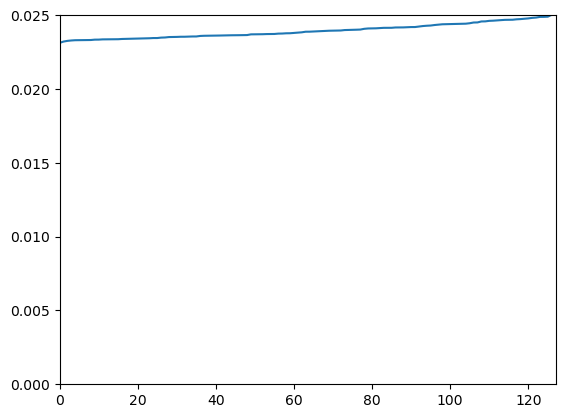

In [367]:
prev_losses = mgd.prev_losses.numpy()
fig, ax = plt.subplots()
ax.plot(prev_losses)
ax.set_xlim((0, len(prev_losses)-1))
ax.set_ylim((0, np.max(prev_losses)))

(0.0, 0.004205325742662553)

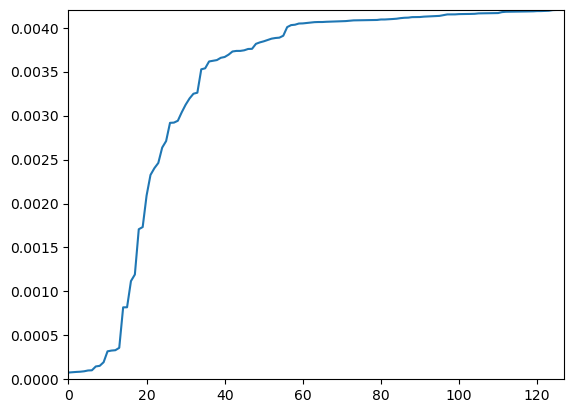

In [357]:
prev_losses = mgd.prev_losses.numpy()
fig, ax = plt.subplots()
ax.plot(prev_losses)
ax.set_xlim((0, len(prev_losses)-1))
ax.set_ylim((0, np.max(prev_losses)))

In [350]:
mgd.prev_losses.tolist()

[0.0041096497696046655, 0.004297880650492149]

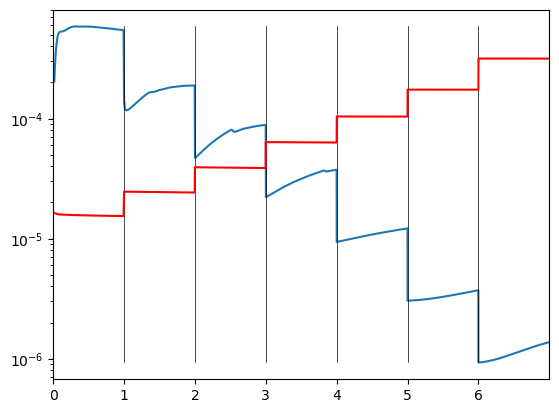

In [294]:
fig, ax = plt.subplots()
lrs = np.array(training_log["lr"])
batch_sizes = np.array(training_log["batch_size"])
_, istart, iinv = np.unique(-batch_sizes, return_index=True, return_inverse=True)
istart = np.append(istart, [len(batch_sizes)])
epochs = np.arange(len(lrs))
epoch_mins = epochs[istart[:-1]]
epoch_maxs = epochs[istart[1:]-1]+1
epochs = iinv + (epochs - epoch_mins[iinv]) / (epoch_maxs[iinv] - epoch_mins[iinv])
ax.plot(epochs, np.maximum(0, lrs))
for i in range(len(istart)):
    ax.plot([i, i], [min(lrs), max(lrs)], color='black', linewidth=0.5)
scaled_loss = np.array(training_log["loss"]) * max(batch_sizes) / batch_sizes**2 / 10**3
ax.plot(epochs, scaled_loss, color='red')
ax.set_xlim((0, max(epochs)))
ax.set_yscale('log')

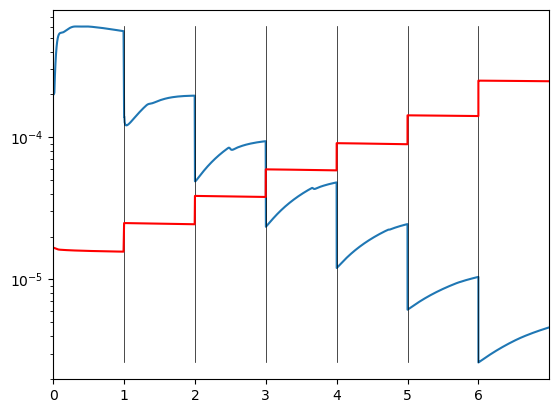

In [355]:
fig, ax = plt.subplots()
lrs = np.array(training_log["lr"])
batch_sizes = np.array(training_log["batch_size"])
_, istart, iinv = np.unique(-batch_sizes, return_index=True, return_inverse=True)
istart = np.append(istart, [len(batch_sizes)])
epochs = np.arange(len(lrs))
epoch_mins = epochs[istart[:-1]]
epoch_maxs = epochs[istart[1:]-1]+1
epochs = iinv + (epochs - epoch_mins[iinv]) / (epoch_maxs[iinv] - epoch_mins[iinv])
ax.plot(epochs, np.maximum(0, lrs))
for i in range(len(istart)):
    ax.plot([i, i], [min(lrs), max(lrs)], color='black', linewidth=0.5)
scaled_loss = np.array(training_log["loss"]) * max(batch_sizes) / batch_sizes**2 / 10**3
ax.plot(epochs, scaled_loss, color='red')
ax.set_xlim((0, max(epochs)))
ax.set_yscale('log')

## Debug gdtuo

In [460]:
losses = mgd.prev_losses
pocket_losses = losses_fn(h_pocket, q)
ii = torch.argsort(pocket_losses)
h_pocket = h_pocket[ii]
pocket_losses = pocket_losses[ii]
print(f"Mean loss: {torch.mean(pocket_losses[:len(losses)]).item():.3g} vs {torch.mean(losses).item():.3g}")
print(f"Min loss: {min(pocket_losses[:len(losses)]).item():.3g} {min(losses).item():.3g}")

Mean loss: 0.0344 vs 0.00469
Min loss: 0.000594 0.000509


In [572]:
h_pocket2 = mgd.h.data.clone().detach()

In [573]:
torch.mean(torch.abs((h_pocket2 - h_pocket2.conj().transpose(-1, -2))**2))

tensor(1.7288e-30, dtype=torch.float64)

In [575]:
torch.mean(torch.abs((h_pocket2 + h_pocket2.conj().transpose(-1, -2))**2))

tensor(1.3902, dtype=torch.float64)

In [535]:
evals, evecs = torch.linalg.eig(h_pocket2)

In [544]:
torch.mean(evals * evals.conj()).real.item()**0.5

1.4736707380955316

In [576]:
gi, gj = GivensLoss.get_ij(h_pocket2)

In [471]:
gi.shape

torch.Size([257, 7])

In [527]:
gij_strs = sorted([[f"{gii}{gji}" for gii, gji in zip(gi[i], gj[i])] for i in range(gi.shape[0])])
gij_unique, gij_counts = np.unique(gij_strs, axis=0, return_counts=True)

In [529]:
gij_unique.shape

(257, 7)

In [577]:
gij_strs = sorted([".".join(f"{gii}{gji}" for gii, gji in zip(gi[i], gj[i])) for i in range(gi.shape[0])])
for gij_str in gij_strs:
    print(gij_str)

01.12.24.13.04.24.23
01.14.24.04.14.04.13
02.01.04.13.02.14.34
02.01.13.04.23.03.23
02.01.23.12.24.34.02
02.04.13.03.02.01.34
02.04.14.04.23.13.02
02.13.03.24.02.04.03
02.13.04.34.04.02.24
02.13.23.34.04.24.01
02.13.23.34.23.12.02
02.14.01.12.24.12.13
02.14.24.13.14.34.02
02.14.34.04.14.02.13
02.24.03.12.24.13.02
02.24.13.02.34.03.24
02.24.13.34.04.34.23
03.13.23.34.02.04.02
03.23.02.01.04.02.34
04.02.13.24.03.04.23
04.12.02.13.24.03.02
04.12.14.13.24.03.04
04.13.02.03.24.34.24
04.13.03.02.04.03.34
04.13.03.02.04.03.34
04.13.24.04.34.24.04
04.13.34.04.23.02.04
04.23.12.13.24.34.02
04.24.13.23.02.24.02
04.24.14.04.13.23.03
12.01.04.13.03.24.02
12.01.13.34.23.04.24
12.01.13.34.23.34.02
12.02.01.04.14.12.13
12.03.13.03.34.24.02
12.03.24.01.13.23.03
12.04.02.13.34.24.03
12.13.03.04.23.34.24
12.13.24.24.02.03.02
12.13.34.04.04.24.04
12.13.34.04.24.13.02
12.13.34.34.04.24.02
12.23.14.24.13.12.02
12.23.34.12.02.04.02
12.24.01.02.23.12.13
12.24.13.03.02.14.03
12.24.14.13.04.14.24
12.24.23.13.2

In [55]:
ALL_INDEX_PAIRS_5 = set([(1<<j)^(1<<i) for i in range(4) for j in range(i+1,5)])
def count_index_pair_lists5(k, excl=[]):
    if k == 0:
        return 1
    res = 0
    cur_pairs = list(ALL_INDEX_PAIRS_5 - set(excl))
    for ij in cur_pairs:
        new_excl = [ij1 for ij1 in excl if (ij1^ij).bit_count() == 4]
        if not all(ij1 < ij for ij1 in new_excl):
            continue
        res += count_index_pair_lists5(k-1, excl=new_excl+[ij])
    return res

# Scratch